In [1]:
import pandas as pd
import re
import string
import numpy as np
import contractions
from num2words import num2words
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from tqdm import tqdm
import matplotlib.pyplot as plt

# Results

We can see all of our datasets have the same length so they can be easily merged.

In [2]:
vader = pd.read_csv('../Data/vader.csv')
logreg = pd.read_csv('../Data/logistic_regression.csv')
svm = pd.read_csv('../Data/svm.csv')
nb = pd.read_csv('../Data/naive_bayes.csv')
print(len(vader), len(logreg), len(svm), len(nb))

179642 179642 179642 179642


In [3]:
df = pd.merge(vader, logreg, on=['overall', 'reviewText', 'asin', 'preprocessed_text'], how='outer')
df = pd.merge(df, svm, on=['overall', 'reviewText', 'asin', 'preprocessed_text'], how='outer')
df = pd.merge(df, nb, on=['overall', 'reviewText', 'asin', 'preprocessed_text'], how='outer')
df = df.rename(columns={'overall': 'original_rating'})
col = df.pop('original_rating')
df.insert(3, 'original_rating', col)
df = df.drop_duplicates()
df.head()

,reviewText,asin,preprocessed_text,original_rating,vader_rating,logistic_rating,svm_rating,bayes_rating
0,I don't spend a lot on my flags because they r...,9539723809,spend lot flag realli get beat lesser qualiti ...,5,5,5,5,5
1,A very dear friend of mine is slowly losing he...,B00000JSZH,dear friend mine slowli lose sight pen make po...,5,5,1,5,5
2,This is absolutely exquisite! It's made of car...,B00000JSZH,absolut exquisit made cardboard like descript ...,5,5,2,5,5
3,"This is really nice to use, however, just not ...",B00000JSZH,realli nice use howev color saddl shimmer give...,4,5,5,3,4
4,This Angel is beautiful. I as so glad I chose ...,B00000JSZH,angel beauti glad chose one even beauti look o...,5,4,1,5,5


In [4]:
len(df)

167907

In [5]:
df.head()

,reviewText,asin,preprocessed_text,original_rating,vader_rating,logistic_rating,svm_rating,bayes_rating
0,I don't spend a lot on my flags because they r...,9539723809,spend lot flag realli get beat lesser qualiti ...,5,5,5,5,5
1,A very dear friend of mine is slowly losing he...,B00000JSZH,dear friend mine slowli lose sight pen make po...,5,5,1,5,5
2,This is absolutely exquisite! It's made of car...,B00000JSZH,absolut exquisit made cardboard like descript ...,5,5,2,5,5
3,"This is really nice to use, however, just not ...",B00000JSZH,realli nice use howev color saddl shimmer give...,4,5,5,3,4
4,This Angel is beautiful. I as so glad I chose ...,B00000JSZH,angel beauti glad chose one even beauti look o...,5,4,1,5,5


When looking at the data, we can see that VADER and Naive Bayes increased the average score whereas SVM and Logistic Regression decreased the average.

In [6]:
df.describe()

,original_rating,vader_rating,logistic_rating,svm_rating,bayes_rating
count,167907.000000,167907.000000,167907.000000,167907.000000,167907.000000
mean,4.091235,4.176508,3.406094,3.704467,4.362069
std,1.305391,1.390841,1.406329,1.392628,1.220969
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4.000000,4.000000,2.000000,3.000000,4.000000
50%,5.000000,5.000000,4.000000,4.000000,5.000000
75%,5.000000,5.000000,5.000000,5.000000,5.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000


Looking at the accuracy (how well the method predicted the acutual rating) we can se that Naive Bayes preformed the best and VADER preformed the worst.

In [7]:
# Calculate accuracy of each method
vader_acc = (df['original_rating'] == df['vader_rating']).sum() / len(df)
logistic_acc = (df['original_rating'] == df['logistic_rating']).sum() / len(df)
svm_acc = (df['original_rating'] == df['svm_rating']).sum() / len(df)
bayes_acc = (df['original_rating'] == df['bayes_rating']).sum() / len(df)

print('Vader accuracy: {:.2%}'.format(vader_acc))
print('Logistic accuracy: {:.2%}'.format(logistic_acc))
print('SVM accuracy: {:.2%}'.format(svm_acc))
print('Bayes accuracy: {:.2%}'.format(bayes_acc))

Vader accuracy: 51.68%
Logistic accuracy: 51.83%
SVM accuracy: 64.54%
Bayes accuracy: 67.30%


As we are trying to redistribute the scores so 5-star ratings are less common, we will check accuracy based on whether the methods predicted within 2 stars of the actual rating. This allows us to count a 5-star review being predicted as low as 3 stars but no lower. By measuring accuracy this way, we can see that SVM performed the best, and both VADER and Logistic Regression tied for the worst.

In [8]:
# create a new column that indicates whether the prediction is correct or not
# based on a change of 3 or more stars between the original rating and predicted rating
df['vader_correct'] = abs(df['vader_rating'] - df['original_rating']) < 3
df['logistic_correct'] = abs(df['logistic_rating'] - df['original_rating']) < 3
df['svm_correct'] = abs(df['svm_rating'] - df['original_rating']) < 3
df['bayes_correct'] = abs(df['bayes_rating'] - df['original_rating']) < 3

# count the number of correct predictions for each method
vader_correct_count = df['vader_correct'].sum()
logistic_correct_count = df['logistic_correct'].sum()
svm_correct_count = df['svm_correct'].sum()
bayes_correct_count = df['bayes_correct'].sum()

# calculate the accuracy of each method
vader_accuracy = vader_correct_count / len(df)
logistic_accuracy = logistic_correct_count / len(df)
svm_accuracy = svm_correct_count / len(df)
bayes_accuracy = bayes_correct_count / len(df)

# print the results
print('Vader accuracy: {:.2%}'.format(vader_accuracy))
print('Logistic accuracy: {:.2%}'.format(logistic_accuracy))
print('SVM accuracy: {:.2%}'.format(svm_accuracy))
print('Bayes accuracy: {:.2%}'.format(bayes_accuracy))

Vader accuracy: 86.19%
Logistic accuracy: 86.19%
SVM accuracy: 93.04%
Bayes accuracy: 92.33%


We can also see that Logistic Regression made the largest changes to the ratings on average. This combined with the low accuracy suggests there have been a lot of large misclassifications, e.g., 5-stars classified as 1 or 2 stars

In [9]:
# create new columns for the absolute difference between the original rating and each new rating
df['vader_diff'] = abs(df['vader_rating'] - df['original_rating'])
df['logistic_diff'] = abs(df['logistic_rating'] - df['original_rating'])
df['svm_diff'] = abs(df['svm_rating'] - df['original_rating'])
df['bayes_diff'] = abs(df['bayes_rating'] - df['original_rating'])

# calculate the mean of each column to get the average difference
vader_avg_diff = df['vader_diff'].mean()
logistic_avg_diff = df['logistic_diff'].mean()
svm_avg_diff = df['svm_diff'].mean()
bayes_avg_diff = df['bayes_diff'].mean()

# print the results
print('Vader average difference: {:.2f}'.format(vader_avg_diff))
print('Logistic average difference: {:.2f}'.format(logistic_avg_diff))
print('SVM average difference: {:.2f}'.format(svm_avg_diff))
print('Bayes average difference: {:.2f}'.format(bayes_avg_diff))

Vader average difference: 0.91
Logistic average difference: 0.93
SVM average difference: 0.60
Bayes average difference: 0.59


Looking at how the data was redistributed we can see that VADER and Naive Bayes tended to increase scores more, whereas SVM and Logistic Regression decreased scores.

In [10]:
# create new columns for whether the new rating is higher or lower than the original rating
df['vader_diff'] = df['vader_rating'] - df['original_rating']
df['vader_up'] = df['vader_diff'] > 0
df['vader_down'] = df['vader_diff'] < 0

df['logistic_diff'] = df['logistic_rating'] - df['original_rating']
df['logistic_up'] = df['logistic_diff'] > 0
df['logistic_down'] = df['logistic_diff'] < 0

df['svm_diff'] = df['svm_rating'] - df['original_rating']
df['svm_up'] = df['svm_diff'] > 0
df['svm_down'] = df['svm_diff'] < 0

df['bayes_diff'] = df['bayes_rating'] - df['original_rating']
df['bayes_up'] = df['bayes_diff'] > 0
df['bayes_down'] = df['bayes_diff'] < 0

# print the results
print('Vader up: {:.2f}%'.format(df['vader_up'].mean() * 100))
print('Vader down: {:.2f}%'.format(df['vader_down'].mean() * 100))
print('Logistic up: {:.2f}%'.format(df['logistic_up'].mean() * 100))
print('Logistic down: {:.2f}%'.format(df['logistic_down'].mean() * 100))
print('SVM up: {:.2f}%'.format(df['svm_up'].mean() * 100))
print('SVM down: {:.2f}%'.format(df['svm_down'].mean() * 100))
print('Bayes up: {:.2f}%'.format(df['bayes_up'].mean() * 100))
print('Bayes down: {:.2f}%'.format(df['bayes_down'].mean() * 100))

Vader up: 28.66%
Vader down: 19.67%
Logistic up: 8.27%
Logistic down: 39.90%
SVM up: 7.96%
SVM down: 27.50%
Bayes up: 23.63%
Bayes down: 9.07%


While Logistic Regression has the fewest 5-star ratings, it also had low acuraccies for both measures. SVM is the only other method to reduce 5-star ratings, it also has a high accuracy which suggests its the best method for our goal.

In [12]:
original_count_5_star = len(df[df['original_rating'] == 5])
vader_count_5_star = len(df[df['vader_rating'] == 5])
logistic_count_5_star = len(df[df['logistic_rating'] == 5])
svm_count_5_star = len(df[df['svm_rating'] == 5])
bayes_count_5_star = len(df[df['bayes_rating'] == 5])

print('Original 5-star count:', original_count_5_star)
print('Vader 5-star count:', vader_count_5_star)
print('Logistic 5-star count:', logistic_count_5_star)
print('SVM 5-star count:', svm_count_5_star)
print('Bayes 5-star count:', bayes_count_5_star)

Original 5-star count: 96225
Vader 5-star count: 112633
Logistic 5-star count: 50830
SVM 5-star count: 69205
Bayes 5-star count: 116869


In [13]:
# Filter the data where the difference between the original rating and predicted rating is less than or equal to 3
df_filtered = df[(abs(df['original_rating'] - df['vader_rating']) <= 2) &
                 (abs(df['original_rating'] - df['logistic_rating']) <= 2) &
                 (abs(df['original_rating'] - df['svm_rating']) <= 2) &
                 (abs(df['original_rating'] - df['bayes_rating']) <= 2)]

# Group the data by the rating column and get the counts for each rating for each method
grouped = df_filtered.groupby(['original_rating'])[['vader_rating', 'logistic_rating', 'svm_rating', 'bayes_rating']].apply(lambda x: x.eq(5).sum())

# Print the result
print(grouped)

                 vader_rating  logistic_rating  svm_rating  bayes_rating
original_rating                                                         
1                           0                0           0             0
2                           0                0           0             0
3                        7930             1143         891          6740
4                       19490             4778        5074         13344
5                       59091            38393       48829         60964


In [14]:
# Get the value counts for each method
original_counts = df ['original_rating'].value_counts()
vader_counts = df['vader_rating'].value_counts()
logistic_counts = df['logistic_rating'].value_counts()
svm_counts = df['svm_rating'].value_counts()
bayes_counts = df['bayes_rating'].value_counts()

# Print the result
print("Original:\n", original_counts)
print("Vader:\n", vader_counts)
print("Logistic:\n", logistic_counts)
print("SVM:\n", svm_counts)
print("Bayes:\n", bayes_counts)

Original:
 5    96225
4    30865
3    15832
1    15104
2     9881
Name: original_rating, dtype: int64
Vader:
 5    112633
4     22022
1     17459
2     14826
3       967
Name: vader_rating, dtype: int64
Logistic:
 5    50830
4    38530
3    29500
2    26090
1    22957
Name: logistic_rating, dtype: int64
SVM:
 5    69205
4    36864
3    23996
1    19147
2    18695
Name: svm_rating, dtype: int64
Bayes:
 5    116869
4     28459
1     16192
3      5275
2      1112
Name: bayes_rating, dtype: int64


Looking at the bar chart, there are a few points of interest. VADER did not allocate many 3 star ratings. This is most likely due to our classification method only allowing 3 stars on a sentiment score of 0 whereas the other rating catagories have a 0.5 range. Naive Bayes also gave very 2 and 3 star reviews. This could be due to the type of langueage used within these reviews as most 1 star reviews contain only negative sentiment so any negative sentiment in 2 or 3 star catagories could make Naive Bayes guess 1 star instead. Here we can once again see that SVM seems to have done a good job as the data is evenly distributed in the same trend as the original data but has given fewer 5 star reviews which aligns whith our original goal.

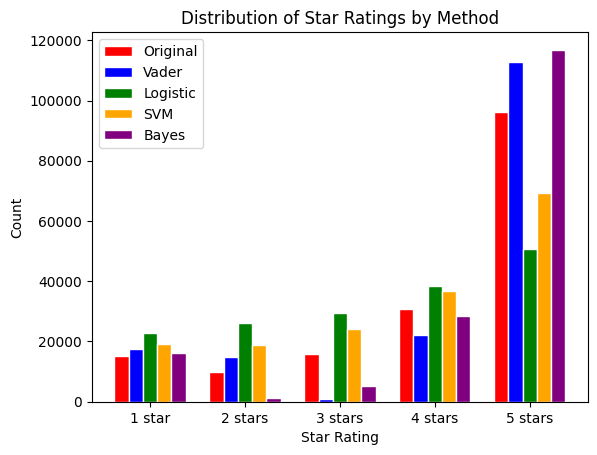

In [15]:
# Data
original = [15104, 9881, 15832, 30865, 96225]
vader = [17459, 14826, 967, 22022, 112633]
logistic = [22957, 26090, 29500, 38530, 50830]
svm = [19147, 18695, 23996, 36864, 69205]
bayes = [16192, 1112, 5275, 28459, 116869]

# X-axis labels
stars = ['1 star', '2 stars', '3 stars', '4 stars', '5 stars']

# Bar width
barWidth = 0.15

# Set position of bar on X-axis
r1 = np.arange(len(original))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]

# Plot bars
plt.bar(r1, original, color='red', width=barWidth, edgecolor='white', label='Original')
plt.bar(r2, vader, color='blue', width=barWidth, edgecolor='white', label='Vader')
plt.bar(r3, logistic, color='green', width=barWidth, edgecolor='white', label='Logistic')
plt.bar(r4, svm, color='orange', width=barWidth, edgecolor='white', label='SVM')
plt.bar(r5, bayes, color='purple', width=barWidth, edgecolor='white', label='Bayes')

# Add X-axis labels
plt.xlabel('Star Rating')
plt.xticks([r + barWidth*2 for r in range(len(original))], stars)

# Add Y-axis label
plt.ylabel('Count')

# Add title
plt.title('Distribution of Star Ratings by Method')

# Add legend
plt.legend()

# Show graphic
plt.show()

In [16]:
# Filter out data misclassified by 3 or more stars
df_filtered = df[(df['vader_rating'] - df['original_rating']).abs() <= 3]
df_filtered = df_filtered[(df_filtered['logistic_rating'] - df_filtered['original_rating']).abs() <= 3]
df_filtered = df_filtered[(df_filtered['svm_rating'] - df_filtered['original_rating']).abs() <= 3]
df_filtered = df_filtered[(df_filtered['bayes_rating'] - df_filtered['original_rating']).abs() <= 3]

In [17]:
# Get the value counts for each method
original_counts = df_filtered['original_rating'].value_counts()
vader_counts = df_filtered['vader_rating'].value_counts()
logistic_counts = df_filtered['logistic_rating'].value_counts()
svm_counts = df_filtered['svm_rating'].value_counts()
bayes_counts = df_filtered['bayes_rating'].value_counts()

# Print the result
print("Original:\n", original_counts)
print("Vader:\n", vader_counts)
print("Logistic:\n", logistic_counts)
print("SVM:\n", svm_counts)
print("Bayes:\n", bayes_counts)

Original:
 5    80503
4    30865
3    15832
2     9881
1     8159
Name: original_rating, dtype: int64
Vader:
 5    100986
4     19273
2     12813
1     11375
3       793
Name: vader_rating, dtype: int64
Logistic:
 5    47451
4    36355
3    27458
2    23714
1    10262
Name: logistic_rating, dtype: int64
SVM:
 5    62769
4    34635
3    21902
2    15959
1     9975
Name: svm_rating, dtype: int64
Bayes:
 5    100393
4     27045
1     11829
3      4933
2      1040
Name: bayes_rating, dtype: int64


Even with miscalssified data filtered out the trends are the same as before. One point of intrest is that Naive Bayes has very few 1-star predictions suggesting that most of the 1-star predictions for this methods were misclassificaitons

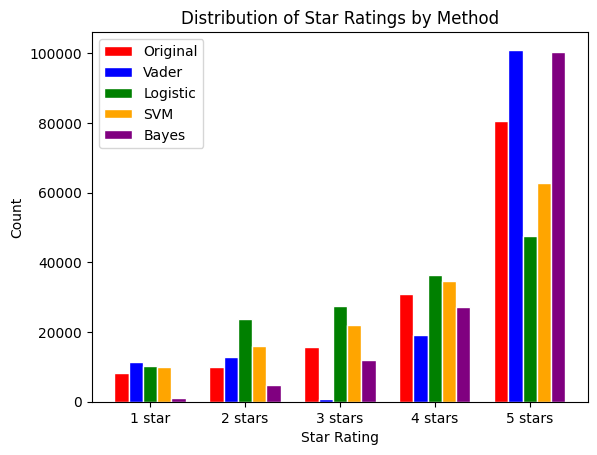

In [18]:
# Data
original = [8159, 9881, 15832, 30865, 80503]
vader = [11375, 12813, 793, 19273, 100986]
logistic = [10262, 23714, 27458, 36355, 47451]
svm = [9975, 15959, 21902, 34635, 62769]
bayes = [1040, 4933, 11829, 27045, 100393]

# X-axis labels
stars = ['1 star', '2 stars', '3 stars', '4 stars', '5 stars']

# Bar width
barWidth = 0.15

# Set position of bar on X-axis
r1 = np.arange(len(original))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]

# Plot bars
plt.bar(r1, original, color='red', width=barWidth, edgecolor='white', label='Original')
plt.bar(r2, vader, color='blue', width=barWidth, edgecolor='white', label='Vader')
plt.bar(r3, logistic, color='green', width=barWidth, edgecolor='white', label='Logistic')
plt.bar(r4, svm, color='orange', width=barWidth, edgecolor='white', label='SVM')
plt.bar(r5, bayes, color='purple', width=barWidth, edgecolor='white', label='Bayes')

# Add X-axis labels
plt.xlabel('Star Rating')
plt.xticks([r + barWidth*2 for r in range(len(original))], stars)

# Add Y-axis label
plt.ylabel('Count')

# Add title
plt.title('Distribution of Star Ratings by Method')

# Add legend
plt.legend()

# Show graphic
plt.show()

In [19]:
vader_misclassified = df[(abs(df['original_rating'] - df['vader_rating']) >= 3)]
logistic_misclassified = df[(abs(df['original_rating'] - df['logistic_rating']) >= 3)]
svm_misclassified = df[(abs(df['original_rating'] - df['svm_rating']) >= 3)]
bayes_misclassified = df[(abs(df['original_rating'] - df['bayes_rating']) >= 3)]

In [20]:
vader_misclassified.head()

,reviewText,asin,preprocessed_text,original_rating,vader_rating,logistic_rating,svm_rating,bayes_rating,vader_correct,logistic_correct,...,logistic_up,logistic_down,svm_up,svm_down,bayes_up,bayes_down,vader_change,logistic_change,svm_change,bayes_change
10,How many times have you had to unscrew a nasty...,B00000JSZH,mani time unscrew nasti bolt leverag get bolt ...,5,1,5,5,4,False,True,...,False,False,False,False,False,True,down,up,up,up
15,"This floor scraper was delivered quickly,and w...",B0000224PU,floor scraper deliv quicklyand exact describ w...,5,2,5,5,4,False,True,...,False,False,False,False,False,True,up,up,up,up
16,"it's a great quick fix-it item, but one has to...",B00002N66T,great quick fixit item one careful overtightne...,2,5,2,2,2,False,True,...,False,False,False,False,False,False,up,up,up,up
38,Just got tired of replacing my cheap $40 box s...,B00002N66D,got tire replac cheap forti box store scott sp...,5,1,1,1,1,False,False,...,False,True,False,True,False,True,down,down,down,down
62,After only 4 months -- using it perhaps twice ...,B00002N680,four month use perhap twice week someth insid ...,1,5,1,2,1,False,True,...,False,False,True,False,False,False,same,up,up,up


In [21]:
logistic_misclassified.head()

,reviewText,asin,preprocessed_text,original_rating,vader_rating,logistic_rating,svm_rating,bayes_rating,vader_correct,logistic_correct,...,logistic_up,logistic_down,svm_up,svm_down,bayes_up,bayes_down,vader_change,logistic_change,svm_change,bayes_change
1,A very dear friend of mine is slowly losing he...,B00000JSZH,dear friend mine slowli lose sight pen make po...,5,5,1,5,5,True,False,...,False,True,False,False,False,False,up,down,up,up
2,This is absolutely exquisite! It's made of car...,B00000JSZH,absolut exquisit made cardboard like descript ...,5,5,2,5,5,True,False,...,False,True,False,False,False,False,up,up,up,up
4,This Angel is beautiful. I as so glad I chose ...,B00000JSZH,angel beauti glad chose one even beauti look o...,5,4,1,5,5,True,False,...,False,True,False,False,False,False,up,down,up,up
6,Performs as described. Allows both sides of th...,B00000JSZH,perform describ allow side propac pb960 batter...,4,3,1,4,4,True,False,...,False,True,False,False,False,False,up,up,up,up
17,An inexpensive way to fix a burst hose. I had ...,B00002N66T,inexpens way fix burst hose anoth one hose met...,5,4,1,1,1,True,False,...,False,True,False,True,False,True,up,down,down,down


In [22]:
svm_misclassified.head()

,reviewText,asin,preprocessed_text,original_rating,vader_rating,logistic_rating,svm_rating,bayes_rating,vader_correct,logistic_correct,...,logistic_up,logistic_down,svm_up,svm_down,bayes_up,bayes_down,vader_change,logistic_change,svm_change,bayes_change
17,An inexpensive way to fix a burst hose. I had ...,B00002N66T,inexpens way fix burst hose anoth one hose met...,5,4,1,1,1,True,False,...,False,True,False,True,False,True,up,down,down,down
21,I've used these for years. A little pricey on ...,B00002N66T,use year littl pricey amazon way go hd one ass...,4,5,4,1,5,True,True,...,False,False,False,True,True,False,up,up,up,up
34,Well built and worth the money. I was short on...,B00002N66D,well built worth money short one lock washer n...,5,5,5,1,1,True,True,...,False,False,False,True,False,True,up,up,down,down
38,Just got tired of replacing my cheap $40 box s...,B00002N66D,got tire replac cheap forti box store scott sp...,5,1,1,1,1,False,False,...,False,True,False,True,False,True,down,down,down,down
59,Spent way too many years doing way too many ac...,B00002N66D,spent way mani year way mani acr yes acr plast...,5,5,3,1,5,True,True,...,False,True,False,True,False,False,up,up,down,up


In [23]:
bayes_misclassified.head()

,reviewText,asin,preprocessed_text,original_rating,vader_rating,logistic_rating,svm_rating,bayes_rating,vader_correct,logistic_correct,...,logistic_up,logistic_down,svm_up,svm_down,bayes_up,bayes_down,vader_change,logistic_change,svm_change,bayes_change
17,An inexpensive way to fix a burst hose. I had ...,B00002N66T,inexpens way fix burst hose anoth one hose met...,5,4,1,1,1,True,False,...,False,True,False,True,False,True,up,down,down,down
34,Well built and worth the money. I was short on...,B00002N66D,well built worth money short one lock washer n...,5,5,5,1,1,True,True,...,False,False,False,True,False,True,up,up,down,down
38,Just got tired of replacing my cheap $40 box s...,B00002N66D,got tire replac cheap forti box store scott sp...,5,1,1,1,1,False,False,...,False,True,False,True,False,True,down,down,down,down
44,This was on my wish list due to positive revie...,B00002N64X,wish list due posit review sent gift friend sp...,4,5,4,4,1,True,True,...,False,False,False,False,False,True,up,up,up,up
45,Our neighbor's gauge always seems to be within...,B00002N64X,neighbor gaug alway seem within one major read...,1,3,1,2,5,True,True,...,False,False,True,False,True,False,up,up,up,same


Looking at an example of a misclassified review, we can see why some misclassifications happen. This review gave 5 stars, but a large amount of the written review was talking about how bad a different product was. This kind of comparative opinion is most likely the cause of this misclassification, as even VADER (a system designed to be able to understand these kinds of opinions) judged the sentiment as negative.

In [24]:
print('Product:', df.iloc[38]['asin'], 'Walk-Behind Push Garden Seeder', '\n')
print(df.iloc[38]['reviewText'], '\n')
print('Original Rating:', df.iloc[38]['original_rating'], '\n')
print('VADER Rating:', df.iloc[38]['vader_rating'], '\n')
print('Logistic Regression Rating:', df.iloc[38]['logistic_rating'], '\n')
print('SVM Rating:', df.iloc[38]['svm_rating'], '\n')
print('Bayes Rating:', df.iloc[38]['bayes_rating'], '\n')

Product: B00002N66D Walk-Behind Push Garden Seeder 

Just got tired of replacing my cheap $40 box store Scott's spreader every year cause the cheap plastic wheels or axle would break. Bought this Earthway 2150 and have now had it a full year. Still performs like new with Zero signs of damage or quality drop off. The large rubber wheels and wide track make using this Earthway on hills or an uneven yards simple. The cheap Scott's would tip over when half full of fertilizer on uneven lawns because of the cheap small plastic wheels and terrible center of gravity. Go ahead and spend the extra money now and have a product that will last a lifetime instead of some cheap garbage that costs more in the long run and has to be replaced every season. 

Original Rating: 5 

VADER Rating: 1 

Logistic Regression Rating: 1 

SVM Rating: 1 

Bayes Rating: 1 



In [25]:
vader_misclassified_low = df[(df['original_rating'] == 1) & (abs(df['original_rating'] - df['vader_rating']) >= 3)]
logistic_misclassified_low = df[(df['original_rating'] == 1) & (abs(df['original_rating'] - df['logistic_rating']) >= 3)]
svm_misclassified_low = df[(df['original_rating'] == 1) & (abs(df['original_rating'] - df['svm_rating']) >= 3)]
bayes_misclassified_low = df[(df['original_rating'] == 1) & (abs(df['original_rating'] - df['bayes_rating']) >= 3)]

In [26]:
vader_misclassified_low.head()

,reviewText,asin,preprocessed_text,original_rating,vader_rating,logistic_rating,svm_rating,bayes_rating,vader_correct,logistic_correct,...,logistic_up,logistic_down,svm_up,svm_down,bayes_up,bayes_down,vader_change,logistic_change,svm_change,bayes_change
62,After only 4 months -- using it perhaps twice ...,B00002N680,four month use perhap twice week someth insid ...,1,5,1,2,1,False,True,...,False,False,True,False,False,False,same,up,up,up
75,I bought several sections of 50' and 100' sect...,B00002N674,bought sever section fifti one hundr section h...,1,5,1,1,1,False,True,...,False,False,False,False,False,False,same,up,up,up
86,"...horse poopoo! Advertised as 600PSI test, 8-...",B00002N674,hors poopoo advertis 600psi test 8pli build ho...,1,4,1,1,1,False,True,...,False,False,False,False,False,False,up,up,up,up
99,This hose is a kink monster. It must have 4 or...,B00002N674,hose kink monster must four five pressur kill ...,1,4,1,2,1,False,True,...,False,False,True,False,False,False,up,up,up,up
160,How can these be a number 1 Best Seller? I am ...,B00002N66H,number one best seller extrem disappoint item ...,1,5,1,1,1,False,True,...,False,False,False,False,False,False,same,up,up,up


In [27]:
logistic_misclassified_low.head()

,reviewText,asin,preprocessed_text,original_rating,vader_rating,logistic_rating,svm_rating,bayes_rating,vader_correct,logistic_correct,...,logistic_up,logistic_down,svm_up,svm_down,bayes_up,bayes_down,vader_change,logistic_change,svm_change,bayes_change
207,Cheaply made....junk. Spring let go after firs...,B00002N66H,cheapli madejunk spring let go first cut open ...,1,1,4,1,1,True,False,...,True,False,False,False,False,False,up,up,up,up
358,This sprinkler is poorly made. The only thing ...,B00002N6AN,sprinkler poor made thing made metal main bodi...,1,5,5,1,5,False,False,...,True,False,False,False,True,False,same,same,up,same
361,I sent an inquiry a few days ago to the compan...,B00002N6AN,sent inquiri day ago compani receiv respons bo...,1,2,4,1,1,True,False,...,True,False,False,False,False,False,up,up,up,up
376,used these to prune small branches from shrubs...,B00002N66H,use prune small branch shrub around hous compl...,1,4,5,2,5,False,False,...,True,False,True,False,True,False,up,same,up,same
662,Craped out after a year the tank is strong but...,B00002N8O1,crape year tank strong plastic pump danger put...,1,1,4,1,1,True,False,...,True,False,False,False,False,False,up,up,up,up


In [28]:
svm_misclassified_low.head()

,reviewText,asin,preprocessed_text,original_rating,vader_rating,logistic_rating,svm_rating,bayes_rating,vader_correct,logistic_correct,...,logistic_up,logistic_down,svm_up,svm_down,bayes_up,bayes_down,vader_change,logistic_change,svm_change,bayes_change
607,Came to my door with a damaged edge and a shre...,B00002N5N7,came door damag edg shred box twice size need ...,1,1,2,4,5,True,True,...,True,False,True,False,True,False,up,up,up,same
845,I looked for a root feeder for several weeks a...,B00002N8GK,look root feeder sever week one bought amazon ...,1,2,1,5,5,True,True,...,False,False,True,False,True,False,up,up,same,same
877,"I have less than a 1/3 acre lot, so I figured ...",B00004DTNC,less thirteen acr lot figur adequ sinc box say...,1,1,1,4,5,True,True,...,False,False,True,False,True,False,up,up,up,same
1094,This tool makes it very easy to dig up the ver...,B00004R9YM,tool make easi dig deep tap root weed especi w...,1,5,4,4,4,False,False,...,True,False,True,False,True,False,same,up,up,up
1158,"I carefully tested two identical hoses, and th...",B00004RA2V,care test two ident hose fail miser rang one t...,1,1,1,4,1,True,True,...,False,False,True,False,False,False,up,up,up,up


In [29]:
bayes_misclassified_low.head()

,reviewText,asin,preprocessed_text,original_rating,vader_rating,logistic_rating,svm_rating,bayes_rating,vader_correct,logistic_correct,...,logistic_up,logistic_down,svm_up,svm_down,bayes_up,bayes_down,vader_change,logistic_change,svm_change,bayes_change
45,Our neighbor's gauge always seems to be within...,B00002N64X,neighbor gaug alway seem within one major read...,1,3,1,2,5,True,True,...,False,False,True,False,True,False,up,up,up,same
161,Didn't work and I sent it back. Arms wouldn't ...,B00002N6AN,work sent back arm would rotat wheel would mov...,1,5,1,1,4,False,True,...,False,False,False,False,True,False,same,up,up,up
216,You can't set it down without it leaking your ...,B00002N67I,set without leak herbicid turn twist realli co...,1,1,2,3,4,True,True,...,True,False,True,False,True,False,up,up,up,up
244,I hate using this sprayer. It's difficult to f...,B00002N67I,hate use sprayer difficult fill small open nee...,1,1,3,3,4,True,True,...,True,False,True,False,True,False,up,up,up,up
245,I bought this for carrying with me while fishi...,B00002N66H,bought carri fish back wood pool hunt run thor...,1,1,2,2,5,True,True,...,True,False,True,False,True,False,up,up,up,same


Looking at a misclassified 1-star review, we can see that this has gone in the opposite direction. Originally the reviewer gave 5-stars but updated the review to give 1-star. As they did not remove the posative section of the review, this was most likley picked up by all of the methods. Additionally, the update section does not contain too many negative sentiment words whcih most likely compounded the issue.

In [33]:
print('Product:', svm_misclassified_low.iloc[3]['asin'], 'Comfort Aluminum Transplanter', '\n')
print(svm_misclassified_low.iloc[3]['reviewText'], '\n')
print('Original Rating:', svm_misclassified_low.iloc[3]['original_rating'], '\n')
print('VADER Rating:', svm_misclassified_low.iloc[3]['vader_rating'], '\n')
print('Logistic Regression Rating:', df.iloc[3]['logistic_rating'], '\n')
print('SVM Rating:', svm_misclassified_low.iloc[3]['svm_rating'], '\n')
print('Bayes Rating:', svm_misclassified_low.iloc[3]['bayes_rating'], '\n')

Product: B00004R9YM Comfort Aluminum Transplanter 

This tool makes it very easy to dig up the very deep tap roots of weeds, especially wild garlic. This is making my spring weeding a much easier task. It seems to be very robust, and I expect it will last a long time. I love it! Update: I'm revising my review from 5 stars to one star. The second time my wife used this, it snapped in two. The "Lightweight, one-piece, polished aluminum alloy" is apparently too lightweight to hold up to the task for which this product was designed. Steel would have been a better choice of material. I do not recommend this product. It didn't last long enough to even wear the label off. 

Original Rating: 1 

VADER Rating: 5 

Logistic Regression Rating: 5 

SVM Rating: 4 

Bayes Rating: 4 

